In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import empyrical
%matplotlib inline

In [2]:
def metric(ret):
    an_ret = empyrical.annual_return(ret, period='monthly')
    vol = empyrical.annual_volatility(ret, period='monthly')
    maxdraw = empyrical.max_drawdown(ret)
    print('Annual return: %.2f%%'%(an_ret*100))
    print('Sharpe ratio: %.2f'%(an_ret / vol))
    print('Annual volatility: %.2f%%'%(vol*100))
    print('Max drawdown: %.2f%%'%(maxdraw*100))

# 读取数据

In [3]:
wind = pd.read_excel('../data/wind.xlsx', index_col=0)

In [4]:
wind.tail()

,Wind Index,Wind Index PE
881001.WI,,
2019-04-30,4180.4348,17.776800
2019-05-31,3913.6616,16.662600
2019-06-28,4045.6673,17.120399
2019-07-31,4041.1186,16.937901
2019-08-30,4011.1518,16.622400


In [5]:
df = pd.read_excel(u'../data/global strategy data.xlsx', sheet_name='data', index_col=0)

In [6]:
df.tail()

,SHCOMP Index,HSI Index,SPXT Index,LUATTRUU Index,CNDR1Y index,SHCOMP Index PE,HSI Index PE,SPX Index PE,FDTRMID Index
1997-12-31 00:00:00,,,,,,,,,
2019-04-30,650.8755,52252.3762,39693.63159,2258.236,1.5,14.8309,11.6566,19.3402,2.375
2019-05-31,599.5030,49097.8631,38111.11128,2311.308,1.5,13.9768,10.5584,18.1155,2.375
2019-06-28,625.3280,52291.8692,40570.77110,2332.635,1.5,14.3378,11.0875,19.2349,2.375
2019-07-31,619.6391,51107.6316,41258.18091,2329.893,1.5,14.1668,10.7904,19.4985,2.125
2019-08-30,587.3439,49300.7465,42211.86264,2409.096,1.5,13.9845,9.9929,19.1597,2.125


In [7]:
df = df.merge(wind, left_index=True, right_index=True)

In [8]:
a_stock, hk_stock, us_stock = 'Wind Index', 'HSI Index', 'SPXT  Index'
asset_columns = [a_stock, hk_stock, us_stock, 'LUATTRUU Index']

In [9]:
assets_ret = df[asset_columns].pct_change()

In [10]:
fed_rate = df['FDTRMID Index']

In [11]:
assets_ret.tail()

,Wind Index,HSI Index,SPXT Index,LUATTRUU Index
2019-04-30,-0.014403,0.026567,0.044008,-0.002776
2019-05-31,-0.063815,-0.060371,-0.039868,0.023502
2019-06-28,0.033729,0.065054,0.064539,0.009227
2019-07-31,-0.001124,-0.022647,0.016943,-0.001175
2019-08-30,-0.007415,-0.035355,0.023115,0.033994


# 计算估值偏离

In [12]:
pe = df[['Wind Index PE', 'HSI Index PE', 'SPX Index PE']]

In [13]:
pe_dev = (pe - pe.rolling(60).mean()) / pe.rolling(60).mean()

In [14]:
pe_dev = pe_dev.dropna()

In [15]:
pe.tail()

,Wind Index PE,HSI Index PE,SPX Index PE
2019-04-30,17.776800,11.6566,19.3402
2019-05-31,16.662600,10.5584,18.1155
2019-06-28,17.120399,11.0875,19.2349
2019-07-31,16.937901,10.7904,19.4985
2019-08-30,16.622400,9.9929,19.1597


# 回测

In [16]:
# 判断当前状态
def regime_weight(date):
    rate_change = fed_rate[fed_rate.index <= date].diff(3).iloc[-1]
    if rate_change == 0:
        return np.array([0.3, 0.3, 0.3, 0.1])
    elif rate_change > 0:
        return np.array([1./3, 1./3, 1./3, 0.])
    else:
        return np.array([0.8/3, 0.8/3, 0.8/3, 0.2])

In [17]:
def weight_change(w, dev):
    if dev < -0.3:
        return w + 0.35
    elif -0.3 <= dev and dev < -0.2:
        return w + 0.25
    elif -0.2 <= dev and dev < -0.1:
        return w + 0.15
    elif 0.1 <= dev and dev < 0.2:
        return max(0, w - 0.15)
    elif 0.2 <= dev and dev < 0.3:
        return max(0, w - 0.25)
    elif dev >= 0.3:
        return max(0, w - 0.35)
    else:
        return w

In [23]:
def calc_weight(date):
#     print(date)
    w = regime_weight(date)
    current_pe_dev = pe_dev[pe_dev.index <= date].loc[date]
    
#     print(w)
    
    init_w = w[:3].sum()
    w[0] = weight_change(w[0], current_pe_dev['Wind Index PE'])
    w[1] = weight_change(w[1], current_pe_dev['HSI Index PE'])
    w[2] = weight_change(w[2], current_pe_dev['SPX Index PE'])
    
#     print(w)

    sum_w = w[:3].sum()
    w[0] = w[0] * init_w / sum_w
    w[1] = w[1] * init_w / sum_w
    w[2] = w[2] * init_w / sum_w
    
#     print(w)

    return w

In [24]:
assets_ret = assets_ret[assets_ret.index >= '2012-01-01']

In [25]:
weight = pd.DataFrame(columns=assets_ret.columns, index=assets_ret.index)
n = assets_ret.shape[1]
wb = np.zeros(n)

for date in weight.index:
    wb = calc_weight(date)
    weight.loc[date] = wb

In [26]:
portfolio = (weight.shift(1) * assets_ret).sum(axis=1)

In [27]:
portfolio.tail()

2019-04-30    0.016574
2019-05-31   -0.046866
2019-06-28    0.047257
2019-07-31   -0.002166
2019-08-30    0.001448
dtype: float64

In [28]:
portfolio = portfolio[portfolio != 0]

In [29]:
metric(portfolio)

Annual return: 12.34%
Sharpe ratio: 1.01
Annual volatility: 12.18%
Max drawdown: -15.67%


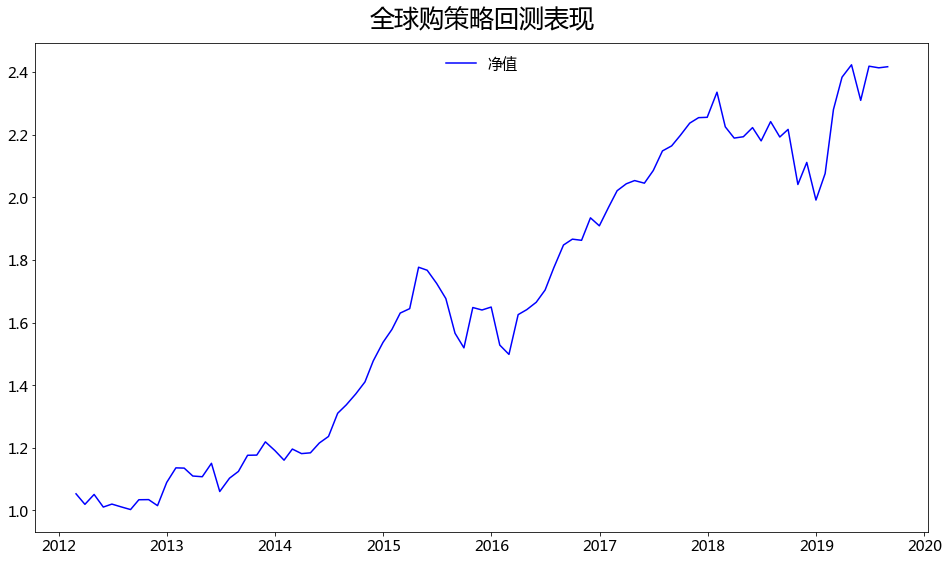

In [30]:
fig, ax = plt.subplots(figsize=(16, 9))

lns1 = ax.plot((1 + portfolio).cumprod(), color='blue', label=u'净值')

lns = lns1
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, frameon=False, fontsize=15, loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1.0))

ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
vals = ax.get_yticks()
ax.set_yticklabels(['{:2.1f}'.format(x) for x in vals])

_ = ax.set_title(u'全球购策略回测表现', fontsize=25, y=1.02)

In [31]:
weight = weight.astype(np.float32)

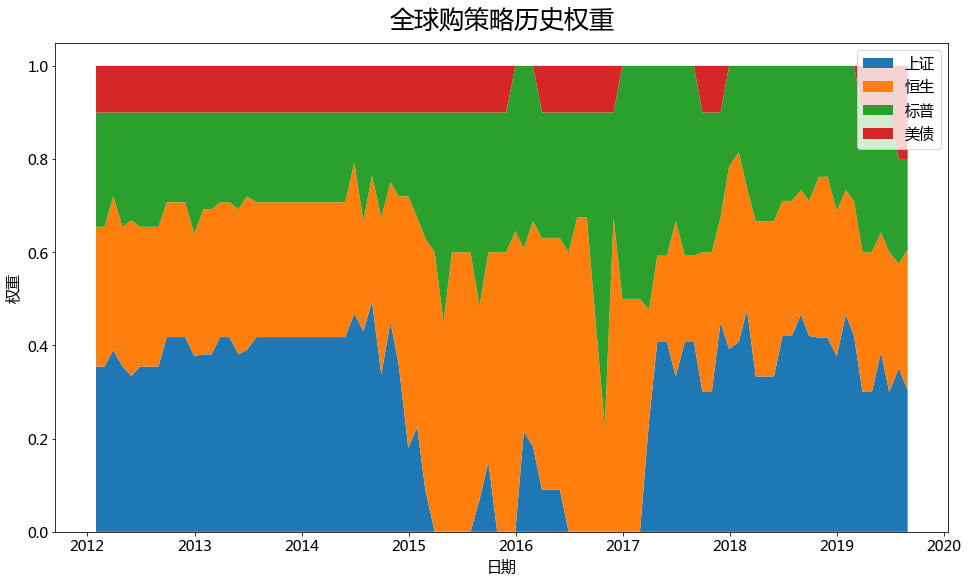

In [32]:
fig, ax = plt.subplots(figsize=(16, 9))
_ = ax.stackplot(weight.index, 
                 weight['Wind Index'],
                 weight['HSI Index'],
                 weight['SPXT  Index'],
                 weight['LUATTRUU Index'],
                 labels=[u'上证', u'恒生', u'标普', u'美债'])
ax.legend(fontsize=15)
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
ax.set_ylabel(u'权重', fontsize=15)
ax.set_xlabel(u'日期', fontsize=15)
_ = ax.set_title(u'全球购策略历史权重', fontsize=25, y=1.02)

In [33]:
weight.tail()

,Wind Index,HSI Index,SPXT Index,LUATTRUU Index
2019-04-30,0.300000,0.300000,0.300000,0.1
2019-05-31,0.385714,0.257143,0.257143,0.1
2019-06-28,0.300000,0.300000,0.300000,0.1
2019-07-31,0.350877,0.224561,0.224561,0.2
2019-08-30,0.303030,0.303030,0.193939,0.2


In [34]:
'%.8f'%(weight['Wind Index'][-1] / 2)

'0.15151516'

In [35]:
'%.8f'%(weight['HSI Index'][-1])

'0.30303031'

In [36]:
'%.8f'%(weight['SPXT  Index'][-1])

'0.19393939'

In [37]:
weight.to_excel('../data/weight.xlsx')